# Example: Cylinder Flow - Part 1/3

- Author: Dr. Daning Huang
- Date: 10/07/2025

## Introduction

In this example we will look at the cylinder flow problem, which has been a classical benchmark case for many dynamics learning algorithms.

- We will start with the functionalities in `DyMAD` that help exploring the data properties.
- Then we will use several model architectures to learn the dynamics, and visualize the results.
- Lastly we will manipulate the learned model to extract as much information as possible.

## Setup

Some imports, and the split of dataset.  The dataset will be used in other parts of this example, so we reload the datasets in the end.

The dataset is obtained from [here](http://dmdbook.com/DATA.zip) - extract `CYLINDER_ALL.mat` to a `./data` folder.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.io import loadmat

from dymad.numerics import DimensionEstimator
from dymad.utils import compare_contour, DataInterface, plot_contour

In [ ]:
raw = loadmat('./data/CYLINDER_ALL.mat')
dat = np.moveaxis(raw['VORTALL'].reshape(449,199,151),(0,1,2),(2,1,0))
Nt, Nx, Ny = dat.shape
ts = np.arange(Nt)
dt = 1.
X = dat.reshape(Nt, -1)

Nspl = 140
np.savez_compressed('data/cylinder.npz', x=X[:Nspl], t=ts[:Nspl])
np.savez_compressed('data/test.npz', x=X[Nspl:], t=ts[Nspl:])

In [3]:
config_path = 'vor_model.yaml'
Nx, Ny = 199, 449

dat = np.load('data/cylinder.npz')
ttrn, Xtrn = dat['t'], dat['x']
dt = ttrn[1] - ttrn[0]

dat = np.load('data/test.npz')
ttst, Xtst = dat['t'], dat['x']

In [ ]:
"""vor_model.yaml
data:
  path: './data/cylinder.npz'
  n_samples: 1
  n_steps: 140
  double_precision: true

split:
  train_frac: 1

dataloader:
  batch_size: 1
"""

## Data Transformations

### The DataInterface class

Recall in model YAML files, the `transform_x` entry defines a series of transforms to pre-process the data before training, and transform the model prediction back to the original data space.  This functionality is available in a standalone mode via the `DataInterface` class, so that the user can explore the structure of the data to inform the choice of model architecture.

Below, as an example to showcase the methods in `DataInterface`, we consider a two-step transformation: first by SVD, then by Diffusion Map (DM).  The DM is a nonlinear dimension reduction algorithm, whose inverse is highly nonlinear; here the Generalized Moving Least Squares (GMLS) method is used as the inverse.  See `dymad/transform/ndr.py::TransformKernel` for the meanings of the parameters.

In [5]:
trn_svd = {
    "type" : "svd",
    "ifcen": True,     # Center the data, i.e., remove the mean
    "order": 0.9999    # Retain 99.99% energy
}
trn_dmf = {
    "type" : "dm",
    "edim": 3,         # Embedding dimension of 3
    "Knn" : 15,
    "Kphi": 3,
    "inverse": "gmls",
    "order": 1,
    "mode": "full"
}

First instantiate a `DataInterface` object, whose syntax is close to `Trainer` classes; upon instantiation it will fit the `Transform` objects given the data in `config` (the training data in our case).  Then apply the transform to the training and test data.

In [6]:
di = DataInterface(config_path=config_path, config_mod={"transform_x" : [trn_svd, trn_dmf]})
Ztrn = di.encode(Xtrn)
Ztst = di.encode(Xtst)
Xrec = di.decode(Ztst)  # Transform back

Now the data is encoded in a 3D latent space, and the latent coordinates are plotted against time as below.  The test data follows the trend of training data well, indicating the chosen transformations are reasonable.  Furthermore, the first coordinate is flat, and the rest seem to follow a harmonic trend - this indicates that the data live on a simple circle-like manifold, which is visually verified in the 3D plot below.

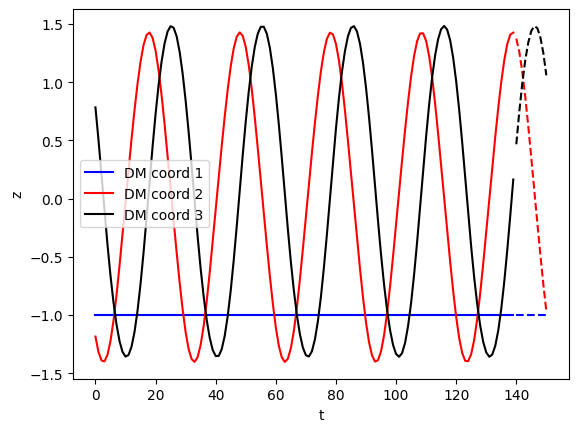

In [7]:
stys = ['b-', 'r-', 'k-']
f = plt.figure()
for _i in range(3):
    plt.plot(ttrn, Ztrn[:,_i], stys[_i], label=f'DM coord {_i+1}')
    plt.plot(ttst, Ztst[:,_i], stys[_i]+'-')
plt.xlabel('t'); plt.ylabel('z'); plt.legend();

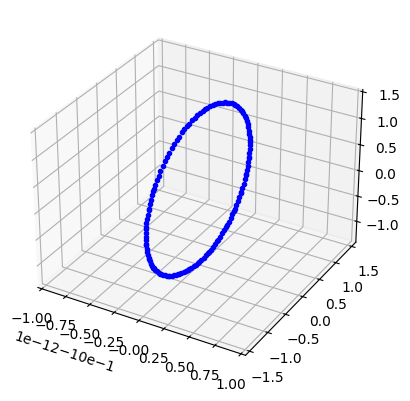

In [8]:
f = plt.figure()
ax = f.add_subplot(111, projection='3d')
ax.plot(*Ztrn.T, 'b.')

As a sanity check, we compare the truth and the reconstructed data at a certain time.  Clearly the error is nearly zero.

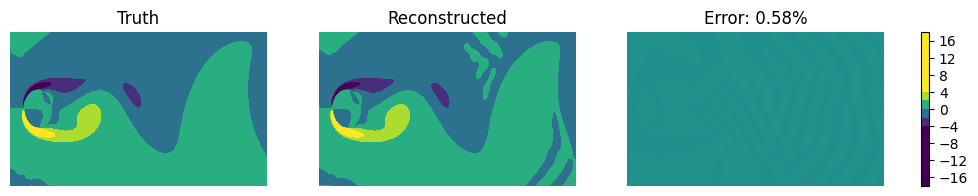

In [9]:
idx = 5
x_tru = Xtst[idx].reshape(Nx, Ny)
x_rec = Xrec[idx].reshape(Nx, Ny)
f, ax = compare_contour(x_tru, x_rec, vmin=-4, vmax=4, figsize=(12, 2))
for _a in ax:
    _a.set_axis_off()

### Intrinsic dimension estimation

To quantitatively determine the intrinsic dimension of the data, `DyMAD` also has a `DimensionEstimator` class, that uses a kernel-based algorithm.  Once we round up the estimation, it is 1D.

> Note that "intrinsic" dimension is the dimension of a "local patch" of data, and is often smaller than the latent dimension.  For example, in a circular data, the latent dimension is 2 (or higher), but its local patch is just an arc, that is 1D; hence the circular structure is intrinsically 1D.

Estimated intrinsic dimension: 1


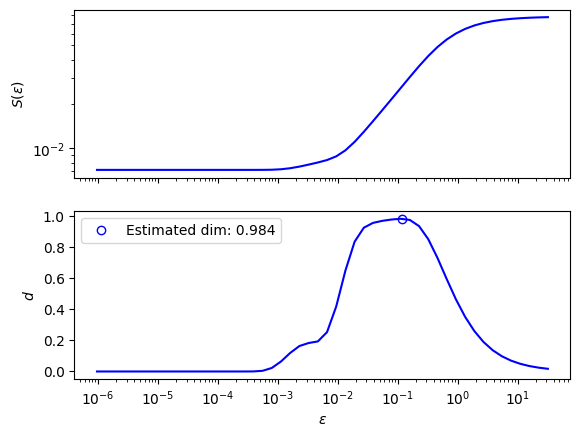

In [10]:
e1 = DimensionEstimator(data=Xtrn, Knn=10, bracket=[-20, 5], tol=0.2)
dim = e1()
print(f"Estimated intrinsic dimension: {dim}")
e1.plot(N=50);

Here is also a sanity check by the local PCA method.  For each data point, the method takes the neighboring points, computes the difference, and performs SVD; the distributions of singular values are overlayed in blue (solid line as average and shade as +/- 1 std).  The first singular value dominates the distribution, indicating one dominant dimension.

As a reference, the red dashed line is the singular values obtained from the full dataset, which has a much longer tail than the local one.

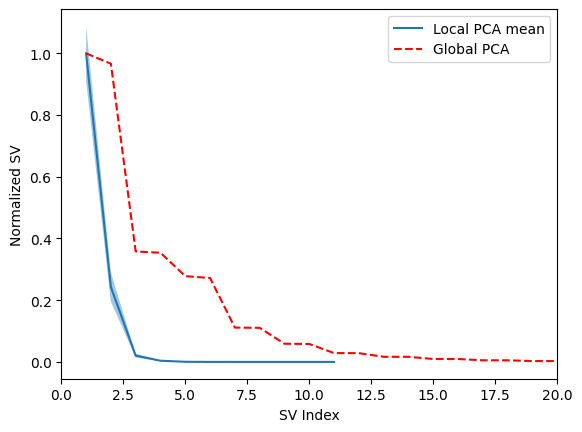

In [11]:
e1.sanity_check()
plt.xlim([0, 20]);

## Further Data Manipulations

### Step-by-step transforms

The data transformations can be done step by step, to probe the intermediate results.

This is done by specifying a `rng` argument.  Think it as `range(*rng)`, so `rng=[0,1]` uses `range(0,1)=[0]` - the first transform (from data to SVD in our case); similarly `[1,2]` uses the second transform (from SVD to DM).

In [12]:
Zsvd = di.encode(Xtst, rng=[0,1])  # Data -> SVD
Zdmf = di.encode(Zsvd, rng=[1,2])  # SVD -> DM
Xsvd = di.decode(Zdmf, rng=[1,2])  # DM -> SVD

At the SVD step, we can extract out and plot the modes, which is done by `get_backward_modes`.  Below the first 5 modes are shown.  The higher order modes correspond to the long tail in global singular values shown earlier.

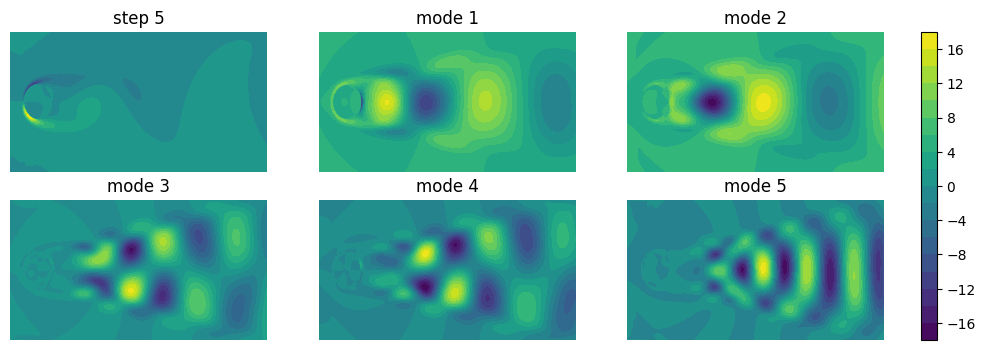

In [13]:
modes_s = di.get_backward_modes(rng=[0,1]).reshape(-1, Nx, Ny)
ref = Xtst[idx].reshape(1, Nx, Ny)
arrays = np.concatenate([ref, modes_s[:5]], axis=0)
labels = [f'step {idx}'] + [f'mode {_i+1}' for _i in range(5)]
f, ax = plot_contour(arrays,
    figsize=(12, 4), colorbar=True, label=labels, grid=(2, 3), mode='contourf')
for _a in ax.flatten():
    _a.set_axis_off()

### Forward and backward modes

In the previous discussion, we used `get_backward_modes`.  As one might guess, there is also `get_forward_modes`.  Their precise definitions are the following:

- In the forward transform, i.e., encoding, say $z=f(x)$, the forward modes are defined as $dz/dx$, which describes how sensitive is $z$ to each entry in $x$.
  + Use SVD as example: $z=f(x)=U^\top (x-x_0)$, so the forward modes are $U^\top$.
- In the backward transform, i.e., decoding, say $x=g(z)$, the backward modes are defined as $dx/dz$, which describes how sensitive is $x$ to each entry in $z$.
  + SVD example again: $x=g(z)=Uz+x_0$, so the backward modes are $U$.
  + Note that in `DyMAD` the transpose of backward modes are returned.

Below let's first look at the backward modes of the combined SVD-DM transform.  Note that for nonlinear transforms, the derivatives are dependent on the data sample.

There are three latent variables, so there are 3 modes.  Mode 1 appears all 0, because $z_1$ is flat and insensitive to any change in $x$.  Modes 2 and 3 are somewhat similar, and only differ in magnitude.  This is due to our implementation, that accounts for the manifold constraint that the data intrinsic dimension is 1; this actually results in collinearity of modes 2 and 3.

> One can change the manifold constraint by setting `order` to 2 or 3 in `trn_dmf`.

In [14]:
modes_b = di.get_backward_modes(ref=Zdmf[idx]).reshape(-1, Nx, Ny)

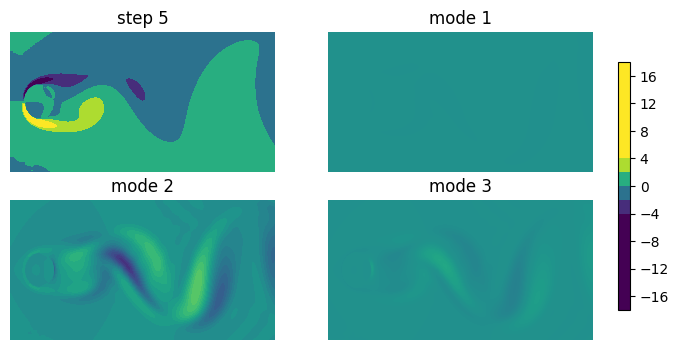

In [15]:
arrays = np.concatenate([ref, modes_b], axis=0)
labels = [f'step {idx}'] + [f'mode {_i+1}' for _i in range(3)]
f, ax = plot_contour(arrays, vmin=-4, vmax=4,
    figsize=(8, 4), colorbar=True, label=labels, grid=(2, 2), mode='contourf')
for _a in ax.flatten():
    _a.set_axis_off()

To understand the backward modes more, note that $\dot{x} = (dx/dz) \dot{z}$.  So the modes relate the rate of change in $z$ to that in $x$.  We can numerically verify this as below - fairly close, up to some inevitable numerical errors.

In [16]:
dXrf = (Xtst[idx+1] - Xtst[idx-1]) / (2*dt)  # Estimate \dot{x} by central difference
dXrf = dXrf.reshape(1, Nx, Ny)
dZrf = (Zdmf[idx+1] - Zdmf[idx-1]) / (2*dt)  # Estimate \dot{z} by central difference
dXdt = np.sum(dZrf[:,None,None] * modes_b, axis=0, keepdims=True)  # Compute \dot{x} by backward modes

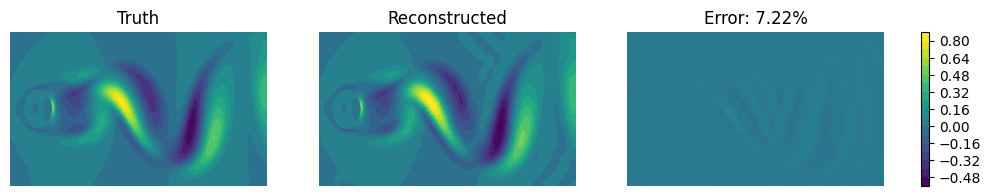

In [17]:
f, ax = compare_contour(dXrf[0], dXdt[0], figsize=(12, 2))
for _a in ax:
    _a.set_axis_off()

With the understanding in backward mode, the forward mode should be relatively straightforward.  In the contours below, again mode 1 is nearly zero, and modes 2 and 3 appear collinear.

In [18]:
modes_f = di.get_forward_modes(ref=Xtst[idx]).reshape(-1, Nx, Ny)

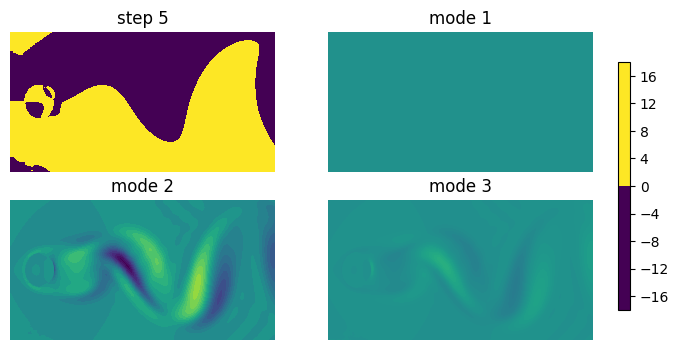

In [19]:
arrays = np.concatenate([ref, modes_f], axis=0)
labels = [f'step {idx}'] + [f'mode {_i+1}' for _i in range(3)]
f, ax = plot_contour(arrays, vmin=-0.0001, vmax=0.0001,
    figsize=(8, 4), colorbar=True, label=labels, grid=(2, 2), mode='contourf')
for _a in ax.flatten():
    _a.set_axis_off()

Similarly we verify the relation $\dot{z} = (dz/dx) \dot{x}$.  It is only three components, so we show in barplots.  The first entry is zero, so no bar is show.  The rest components are again fairly close.

Text(0, 0.5, 'Rate')

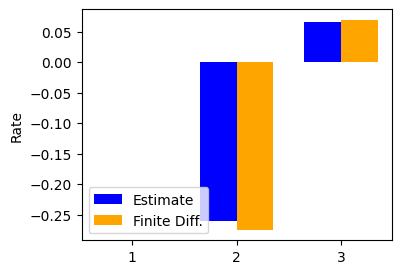

In [20]:
dZdt = np.sum(dXrf * modes_f, axis=(1,2))

f = plt.figure(figsize=(4,3))
labels = ['1', '2', '3']
values = np.stack([dZdt, dZrf], axis=1)  # shape (3,2)
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, values[:,0], width, label='Estimate', color='blue')
plt.bar(x + width/2, values[:,1], width, label='Finite Diff.', color='orange')
plt.xticks(x, labels)
plt.legend()
plt.ylabel('Rate')

One thing that one may have noted is the difference in the magnitudes in the modes.  The forward modes are *tiny*.

One way to think about this is the following: All entries of $x$ and $z$ are $O(1)$, but $dim(x)$ is $O(10^4)$; if $z=Ax$ then we must have entries of $A$ as $O(10^{-4})$ to maintain the correct order of magnitude.

Also, one may verify that the tiny forward modes are "compatible" with backward modes, by noting that $(dz/dx)(dx/dz)=I$ if both terms are full rank.  This product is in the first plot below.  In our case the modes are rank-1, so we end up with one dominant entry.

Furthermore, one can also explore the forward and backward modes themselves.  For example, in forward, note the identity
$$
\|\dot{x}\|^2 = \left\|\frac{dx}{dz}\dot{z}\right\|^2 = \dot{z}^\top\left(\frac{dx}{dz}\right)^\top\frac{dx}{dz}\dot{z} \equiv \dot{z}^\top M \dot{z}
$$
So the product $M$ is a "metric" that converts the size of $\dot{z}$ to that of $\dot{x}$.  From the plot below, we can also see it is mainly $z_2$ that is contributing to the change in $x$ at the given time.

/var/folders/q5/n6wq35sd357_lwxlbgdsv4sw0000gn/T/ipykernel_31579/3155367673.py:5: RuntimeWarning: divide by zero encountered in matmul
  im0 = ax[0].imshow(_f @ _b.T, vmin=-1, vmax=1, cmap='bwr')
/var/folders/q5/n6wq35sd357_lwxlbgdsv4sw0000gn/T/ipykernel_31579/3155367673.py:5: RuntimeWarning: overflow encountered in matmul
  im0 = ax[0].imshow(_f @ _b.T, vmin=-1, vmax=1, cmap='bwr')
/var/folders/q5/n6wq35sd357_lwxlbgdsv4sw0000gn/T/ipykernel_31579/3155367673.py:5: RuntimeWarning: invalid value encountered in matmul
  im0 = ax[0].imshow(_f @ _b.T, vmin=-1, vmax=1, cmap='bwr')


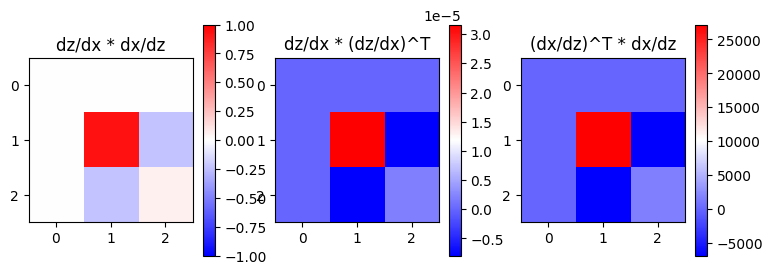

In [21]:
_f = modes_f.reshape(3, -1)
_b = modes_b.reshape(3, -1)

f, ax = plt.subplots(1, 3, figsize=(9, 3))
im0 = ax[0].imshow(_f @ _b.T, vmin=-1, vmax=1, cmap='bwr')
ax[0].set_title('dz/dx * dx/dz')
plt.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(_f @ _f.T, cmap='bwr')
ax[1].set_title('dz/dx * (dz/dx)^T')
plt.colorbar(im1, ax=ax[1])

im2 = ax[2].imshow(_b @ _b.T, cmap='bwr')
ax[2].set_title('(dx/dz)^T * dx/dz')
plt.colorbar(im2, ax=ax[2])